# **MNIST Classification w/ CNN**

## **1. Settings**

In [1]:
import os
import random
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms  # Data augmentation

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# PyTorch 버전 확인
print(f'PyTorch version : {torch.__version__}')

# GPU 사용 가능 여부 확인
print(f'CUDA 사용 가능 : {torch.cuda.is_available()}')

# MacOS에서 MPS(Multi-Process Service)를 사용할 수 있는지 확인
print(f'MPS 사용 가능 : {torch.backends.mps.is_available()}')


# 디바이스 지정
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'학습 디바이스 : {device}')

PyTorch version : 2.1.0
CUDA 사용 가능 : False
MPS 사용 가능 : True
학습 디바이스 : mps


In [3]:
# 재현성을 위한 random seed 설정
# https://pytorch.org/docs/stable/notes/randomness.html

SEED = 2023
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [4]:
# 네트워크 구조를 정하기 위한 하이퍼파라미터 (CNN 레이어 적용 후 FC 레이어 적용)
CONV_DIMS = [32, 64]
FC_DIMS = [128]

# 학습에 필요한 하이퍼파라미터
LEARNING_RATE = 0.001
N_EPOCH = 30
PRINT_EVERY = 1
BATCH_SIZE = 128

## **2. Prepare MNIST Dataset**

In [5]:
# MNIST 데이터셋을 불러오기 위한 transform 정의 (텐서로 변환, 정규화)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)])

# Data Augmentation을 위한 transform 정의
# (숫자의 경우 회전이나 뒤집기에 대한 변화를 주면 안되므로, 약간의 이동 및 회전만 허용)
transform_train = transforms.Compose([transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)])

# MNIST 데이터셋 다운로드 및 불러오기 (학습데이터)
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transform_train,
                          download=True)

# MNIST 데이터셋 다운로드 및 불러오기 (테스트데이터)
mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transform,
                         download=True)

# 데이터셋의 크기 확인
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1))
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           ) 

Done.


In [6]:
# 데이터로더 정의하기 (학습데이터: 미니배치, 데이터순서섞음, 멀티프로세싱)
train_iter = torch.utils.data.DataLoader(mnist_train,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=1)

# 데이터로더 정의하기 (테스트데이터: 미니배치, 멀티프로세싱)
test_iter = torch.utils.data.DataLoader(mnist_test,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=1)

print ("Done.")

Done.


## **3. Create CNN Model**
- 모델 구조

    ```
    [Input] 1 * 28 * 28 
    -> (CNN layer with 3*3 kernel and stride 1)
        32 * 28 * 28
    -> (Max-pooling)
        32 * 14 * 14
    -> (CNN layer with 3*3 kernel and stride 1)
        64 * 14 * 14
    -> (Max-pooling)
        64 * 7 * 7
    -> (MLP/FC/Dense layer)
        128
    -> (MLP/FC/Dense layer)
    [Output] 10
    ```

- 활성화 함수로는 ReLU를 사용

- 정규화 및 드롭아웃을 선택적으로 사용할 수 있도록 설정

    - 정규화로는 배치 정규화, 그룹 정규화 등을 선택할 수 있음

In [7]:
class CNN(nn.Module):
    '''Convolutional Neural Network (CNN)'''
    def __init__(self, xdim=[1,28,28], ydim=[10],
                 ksize=3, conv_dims=[32,64], psize=2, 
                 fc_dims=[1024,128],
                 dropout_p=0, norm_type='bn'):
        '''
        xdim: 입력 데이터의 차원 (1, 28, 28)
        ksize: 합성곱 필터(filter; kernel)의 크기
        psize: 풀링(pooling)의 크기
        conv_dims: 각 convolution layer의 output channel 수를 담은 리스트
        fc_dims: 각 FC layer의 노드 수를 담은 리스트
        dropout_p: dropout 확률 (0~1, 0이면 dropout을 사용하지 않음)
        norm_type: normalization의 종류 (bn, ln, gn, 없으면 사용하지 않음)
        '''
        super(CNN, self).__init__()

        # 각종 layer를 담을 리스트 (nn.ModuleList 사용)
        self.layers = nn.ModuleList()
        prev_cdim = xdim[0]

        # Convolution layer 반복
        for cdim in conv_dims:
            # Convolution layer
            self.layers.append(nn.Conv2d(in_channels=prev_cdim, 
                                         out_channels=cdim,
                                         kernel_size=ksize,
                                         padding=ksize//2,
                                         stride=1))
            
            # Normalization layer
            if norm_type == 'bn':
                self.layers.append(nn.BatchNorm2d(num_features=cdim))
            elif norm_type == 'ln':
                self.layers.append(nn.LayerNorm(normalized_shape=[cdim, xdim[1], xdim[2]]))
            elif norm_type == 'gn':
                self.layers.append(nn.GroupNorm(num_groups=4, num_channels=cdim))

            # ReLU
            self.layers.append(nn.ReLU())
            
            # Dropout
            if dropout_p:
                self.layers.append(nn.Dropout2d(dropout_p))

            # Pooling layer
            if psize:
                self.layers.append(nn.MaxPool2d(psize, psize))

            prev_cdim = cdim
            xdim = [cdim, xdim[1]//psize, xdim[2]//psize]

        # FC layer
        self.layers.append(nn.Flatten())
        prev_hdim = xdim[0]*xdim[1]*xdim[2]
        for hdim in fc_dims:
            self.layers.append(nn.Linear(prev_hdim, hdim))
            self.layers.append(nn.ReLU())
            if dropout_p:
                self.layers.append(nn.Dropout(dropout_p))
            prev_hdim = hdim

        # 출력 레이어
        self.layers.append(nn.Linear(prev_hdim, ydim[0]))

        # 각 레이어에 이름을 부여
        for idx, layer in enumerate(self.layers):
            self.add_module(f'{type(layer).__name__}_{idx}', layer)

        # 가중치 초기화 함수 호출
        self.init_weights()

    ''' 순방향 전파 (함수 이름은 forward로 고정)'''
    def forward(self, x):
        # Convolution layer -> Norm -> ReLU -> Dropout -> Pooling 반복
        # FC layer -> ReLU -> Dropout 반복
        for layer in self.layers:
            x = layer(x)

        return x  # (batch_size, 10)

    ''' 모델 가중치 초기화 함수 '''
    def init_weights(self):
        # self.modules()는 모델의 모든 레이어를 반복하는 generator를 반환
        for m in self.modules():
            # nn.Conv2d, nn.Linear 레이어만 가중치 초기화
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)


## **4. Prepare for Training**

In [8]:
# CNN 모델 생성 (CONV_DIMS = (32, 64), FC_DIMS = (512, 128, 32), 드롭아웃 미사용, 그룹정규화 사용)
model = CNN(xdim=[1,28,28], ydim=[10],
            ksize=3, conv_dims=CONV_DIMS, psize=2, 
            fc_dims=FC_DIMS,
            dropout_p=0, norm_type=None).to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss().to(device)

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
# 모델 파라미터 확인
for idx, m in enumerate(model.modules()):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        print(f'{idx}번째 레이어:')
        print(f'\t{m}')
        print(f'\tweight: {m.weight.shape}')
        print(f'\tbias: {m.bias.shape}')
        print()


2번째 레이어:
	Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
	weight: torch.Size([32, 1, 3, 3])
	bias: torch.Size([32])

5번째 레이어:
	Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
	weight: torch.Size([64, 32, 3, 3])
	bias: torch.Size([64])

9번째 레이어:
	Linear(in_features=3136, out_features=128, bias=True)
	weight: torch.Size([128, 3136])
	bias: torch.Size([128])

11번째 레이어:
	Linear(in_features=128, out_features=10, bias=True)
	weight: torch.Size([10, 128])
	bias: torch.Size([10])



In [10]:
def acc_fn(output, target):
    '''정확도 계산 함수'''
    with torch.no_grad():
        # output: (batch_size, 10)
        # target: (batch_size)
        pred = output.argmax(dim=1, keepdim=True)  # (batch_size, 1)
        correct = pred.eq(target.view_as(pred)).sum()  # True: 1, False: 0
        acc = correct.float() / target.size(0)  # 정확도 = 맞은 개수 / 전체 개수

        return acc.item()

def acc_model(model, data_iter, device):
    '''모델 정확도 계산 함수'''
    with torch.no_grad():
        corrects, total = 0, 0
        for batch in data_iter:
            x, y = batch[0].to(device), batch[1].to(device)
            output = model(x)
            corrects += (output.argmax(dim=1) == y).sum().item()
            total += y.size(0)
    
    return corrects / total

## **5. Train & Test**

In [11]:
# 학습 시작
model.train()  # train mode로 변경

# N_EPOCH 만큼 반복
for epoch in tqdm(range(N_EPOCH)):
    train_cost, train_acc = 0, 0

    # train_iter에서 미니배치를 하나씩 꺼내옴
    for X, Y in train_iter:
        # 모델이 GPU 메모리에 올라가 있는 경우, 미니배치도 GPU 메모리에 올려야 함
        X = X.to(device)
        Y = Y.to(device)

        # Gradient를 0으로 초기화 (backward()를 하기 전에 꼭 해야 함)
        optimizer.zero_grad()
        # 순방향 전파
        hypothesis = model(X)
        # 손실값 계산
        cost = criterion(hypothesis, Y)
        # 역전파 (Gradient 계산)
        cost.backward()
        # 파라미터 업데이트
        optimizer.step()

        # 현재 미니배치의 손실값 및 정확도 계산
        train_cost += cost.item()
        train_acc += acc_fn(hypothesis, Y)
    
    # Print the average cost in every PRINT_EVERY epoch
    if (epoch+1) % PRINT_EVERY == 0:
        avg_cost = train_cost / len(train_iter)
        avg_acc = train_acc / len(train_iter)
        print(f'[Epoch {epoch+1:2d}/{N_EPOCH:2d}] '
              f'Train Cost: {avg_cost:.9f} | Acc: {avg_acc*100:.2f} %')

print('Learning finished')

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch  1/30] Train Cost: 0.508304817 | Acc: 85.12 %
[Epoch  2/30] Train Cost: 0.128524051 | Acc: 96.11 %
[Epoch  3/30] Train Cost: 0.098269160 | Acc: 96.97 %
[Epoch  4/30] Train Cost: 0.078519402 | Acc: 97.59 %
[Epoch  5/30] Train Cost: 0.068523667 | Acc: 97.84 %
[Epoch  6/30] Train Cost: 0.064369608 | Acc: 97.99 %
[Epoch  7/30] Train Cost: 0.056535575 | Acc: 98.25 %
[Epoch  8/30] Train Cost: 0.050777571 | Acc: 98.41 %
[Epoch  9/30] Train Cost: 0.048101500 | Acc: 98.50 %
[Epoch 10/30] Train Cost: 0.044560715 | Acc: 98.59 %
[Epoch 11/30] Train Cost: 0.041304078 | Acc: 98.72 %
[Epoch 12/30] Train Cost: 0.041008853 | Acc: 98.72 %
[Epoch 13/30] Train Cost: 0.039026110 | Acc: 98.74 %
[Epoch 14/30] Train Cost: 0.037980412 | Acc: 98.80 %
[Epoch 15/30] Train Cost: 0.035321895 | Acc: 98.90 %
[Epoch 16/30] Train Cost: 0.034032809 | Acc: 98.96 %
[Epoch 17/30] Train Cost: 0.031638551 | Acc: 98.99 %
[Epoch 18/30] Train Cost: 0.030374321 | Acc: 99.04 %
[Epoch 19/30] Train Cost: 0.030366461 | Acc: 9

In [12]:
# 테스트 데이터셋에 대한 정확도 계산    
model.eval()  # evaluation mode로 변경
test_acc = acc_model(model, test_iter, device)
print(f'Test Acc: {test_acc*100:.2f} %')

Test Acc: 99.32 %


## **6. Visualization**

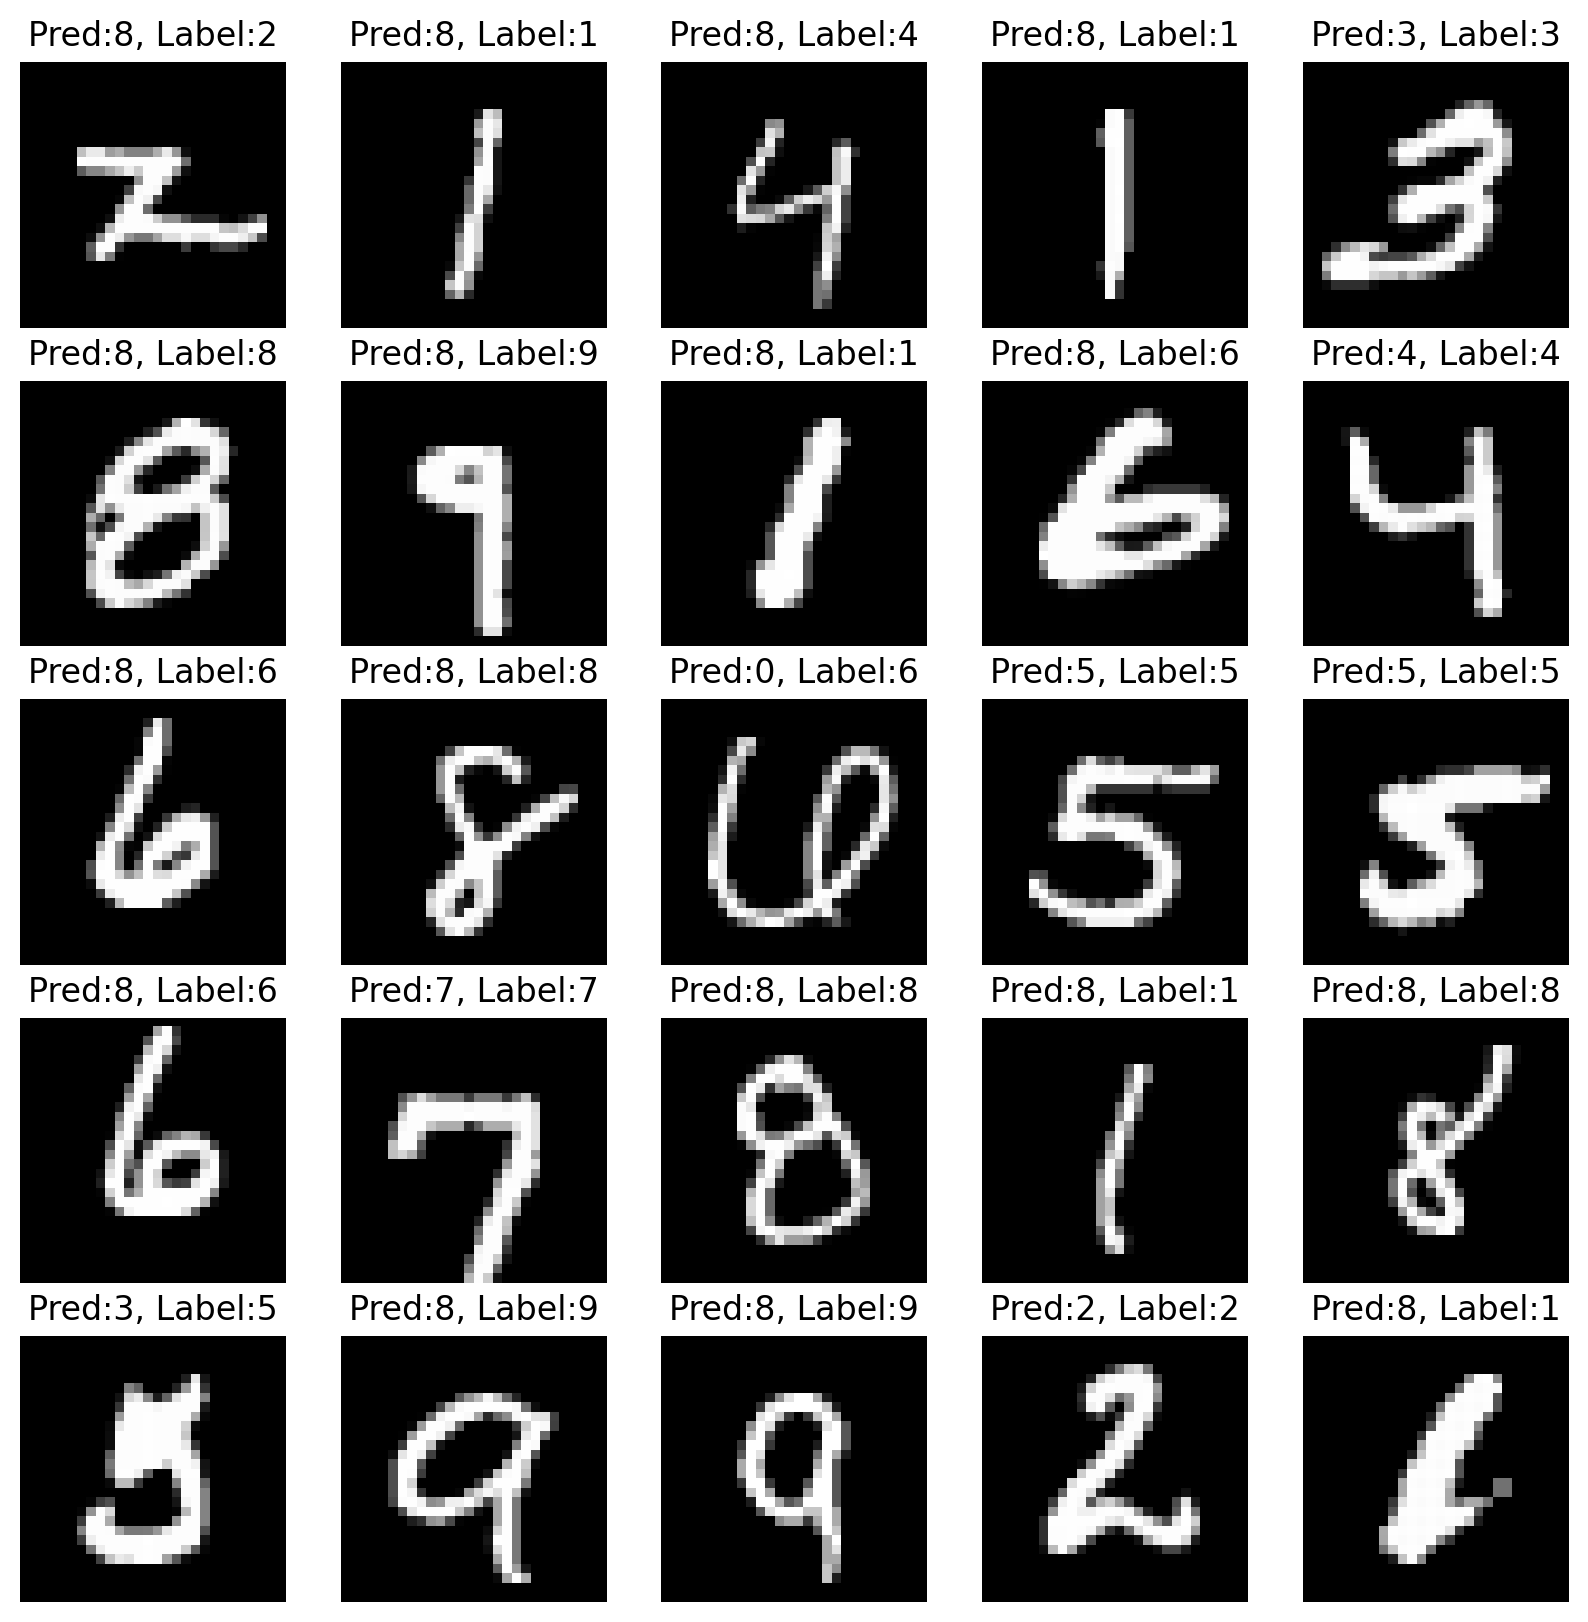

In [13]:
model.eval()
with torch.no_grad():
    n_sample = 25  # number of samples
    
    # n_sample개의 테스트 데이터를 랜덤하게 선택
    sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
    test_x = mnist_test.data[sample_indices]
    test_y = mnist_test.targets[sample_indices]

    # 모델에 입력으로 넣어서 예측값을 계산
    y_pred = model(test_x.view(-1, 1, 28, 28).float().to(device)).argmax(dim=1).cpu().numpy()

    
    # 5x5 grid로 테스트 이미지와 예측값 출력
    plt.figure(figsize=(10,10))
    for idx in range(n_sample):
        plt.subplot(5, 5, idx+1)  # 5x5 grid에서의 위치 지정
        plt.imshow(test_x[idx], cmap='gray')  # 이미지 출력
        plt.axis('off')  # x축과 y축의 눈금 출력하지 않음
        plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))  # 예측값과 실제값 출력
    plt.show()  # 그림 출력

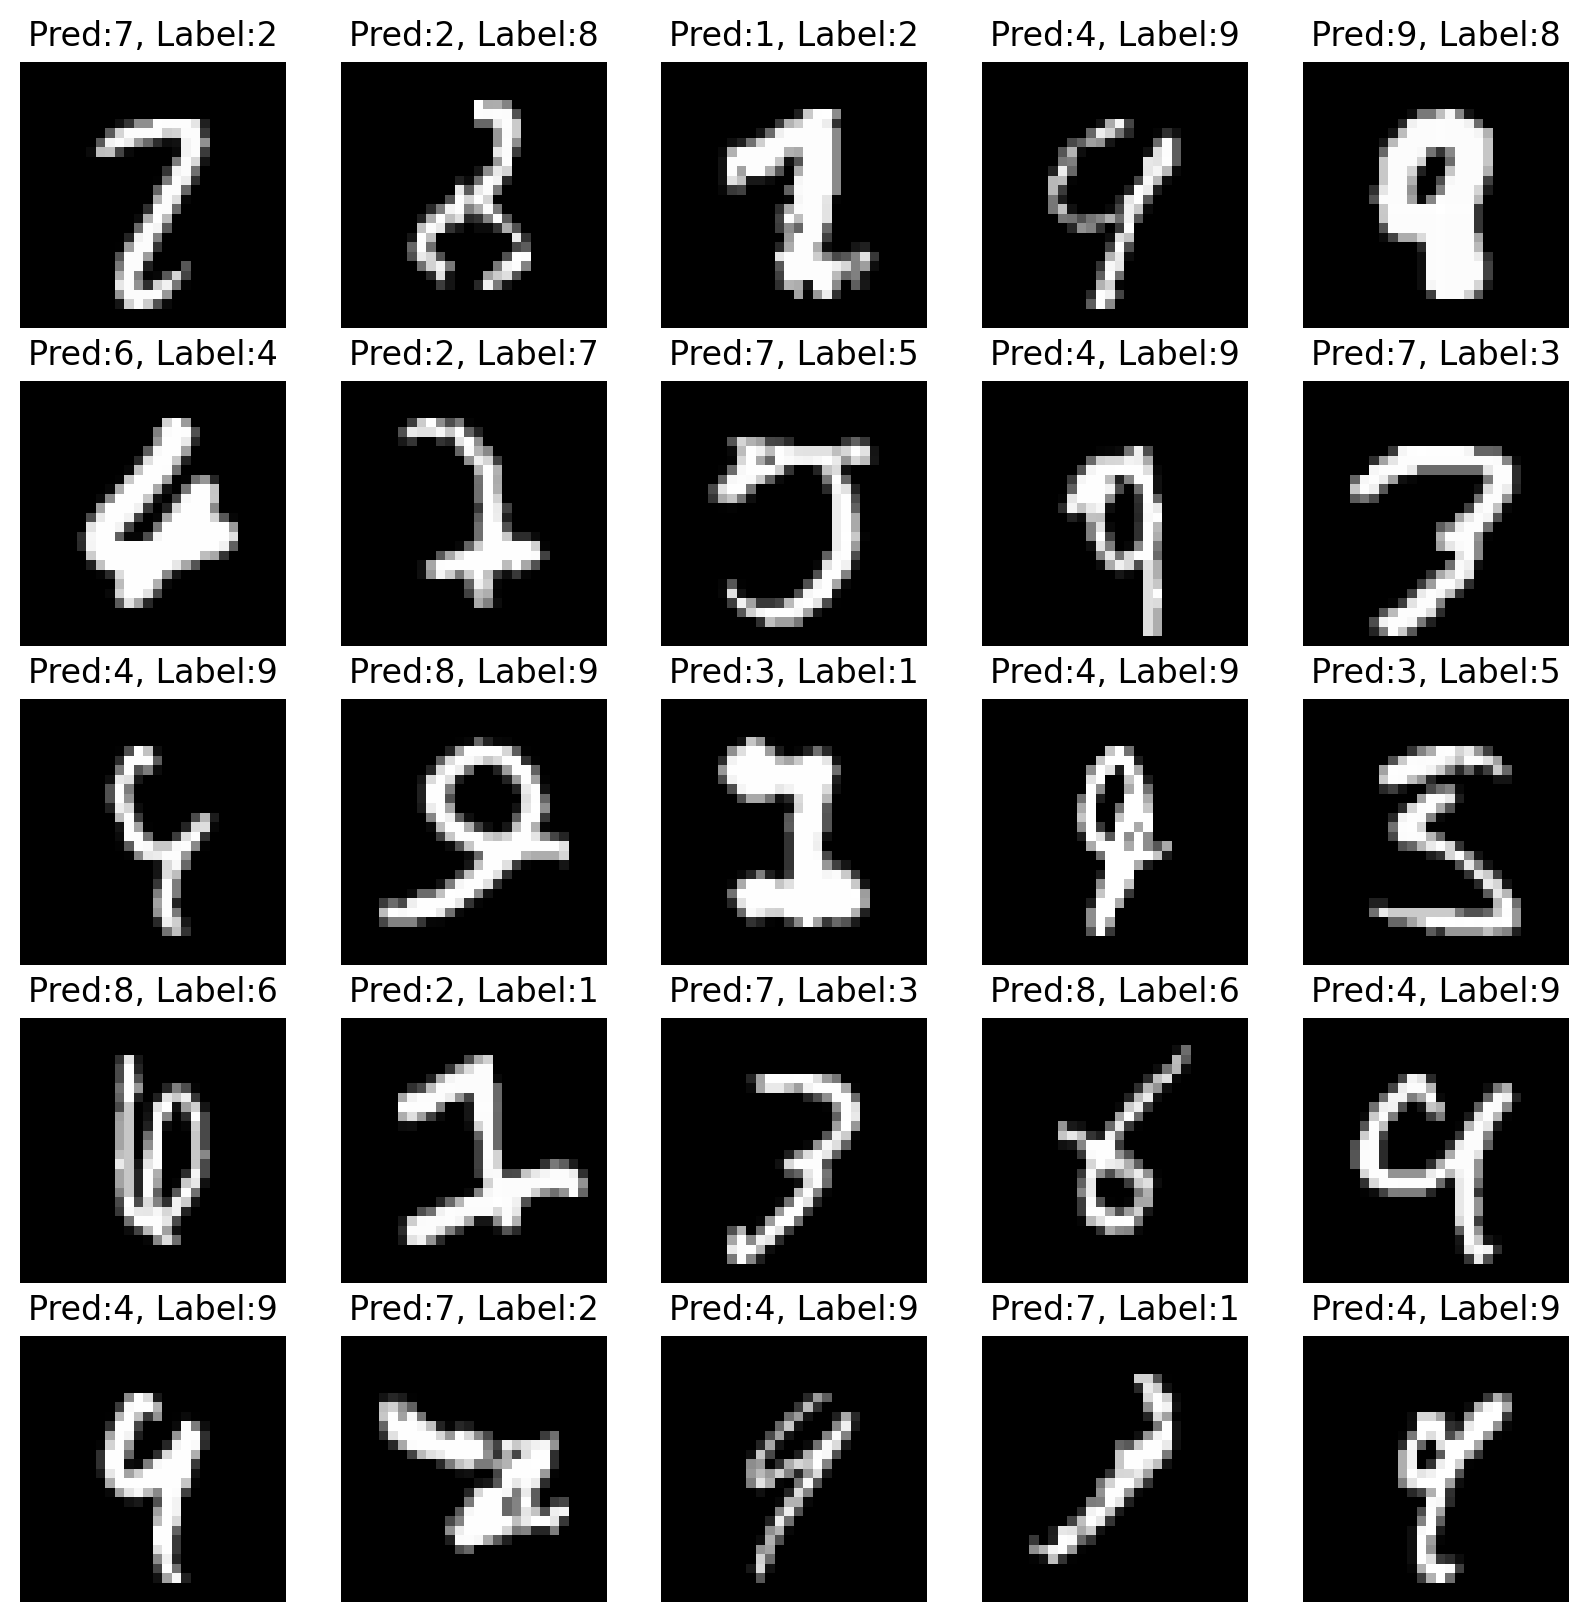

In [14]:
# 정답이 아닌 예측값을 가진 테스트 데이터를 랜덤하게 선택하여 출력
model.eval()
with torch.no_grad():
    n_sample = 25  # number of samples
    img, t, p = [], [], []
    for batch in test_iter:
        x, y = batch[0].to(device), batch[1].to(device)
        output = model(x)
        y_pred = output.argmax(dim=1)
        for i in range(len(y)):
            if y[i] != y_pred[i]:
                img.append(x[i].cpu())
                t.append(y[i].cpu())
                p.append(y_pred[i].cpu())
                if len(x) >= n_sample:
                    break
                
    plt.figure(figsize=(10,10))
    for idx in range(n_sample):
        plt.subplot(5, 5, idx+1)  # 5x5 grid에서의 위치 지정
        plt.imshow(img[idx].view(28,28), cmap='gray')  # 이미지 출력
        plt.axis('off')  # x축과 y축의 눈금 출력하지 않음
        plt.title("Pred:%d, Label:%d"%(p[idx],t[idx]))  # 예측값과 실제값 출력

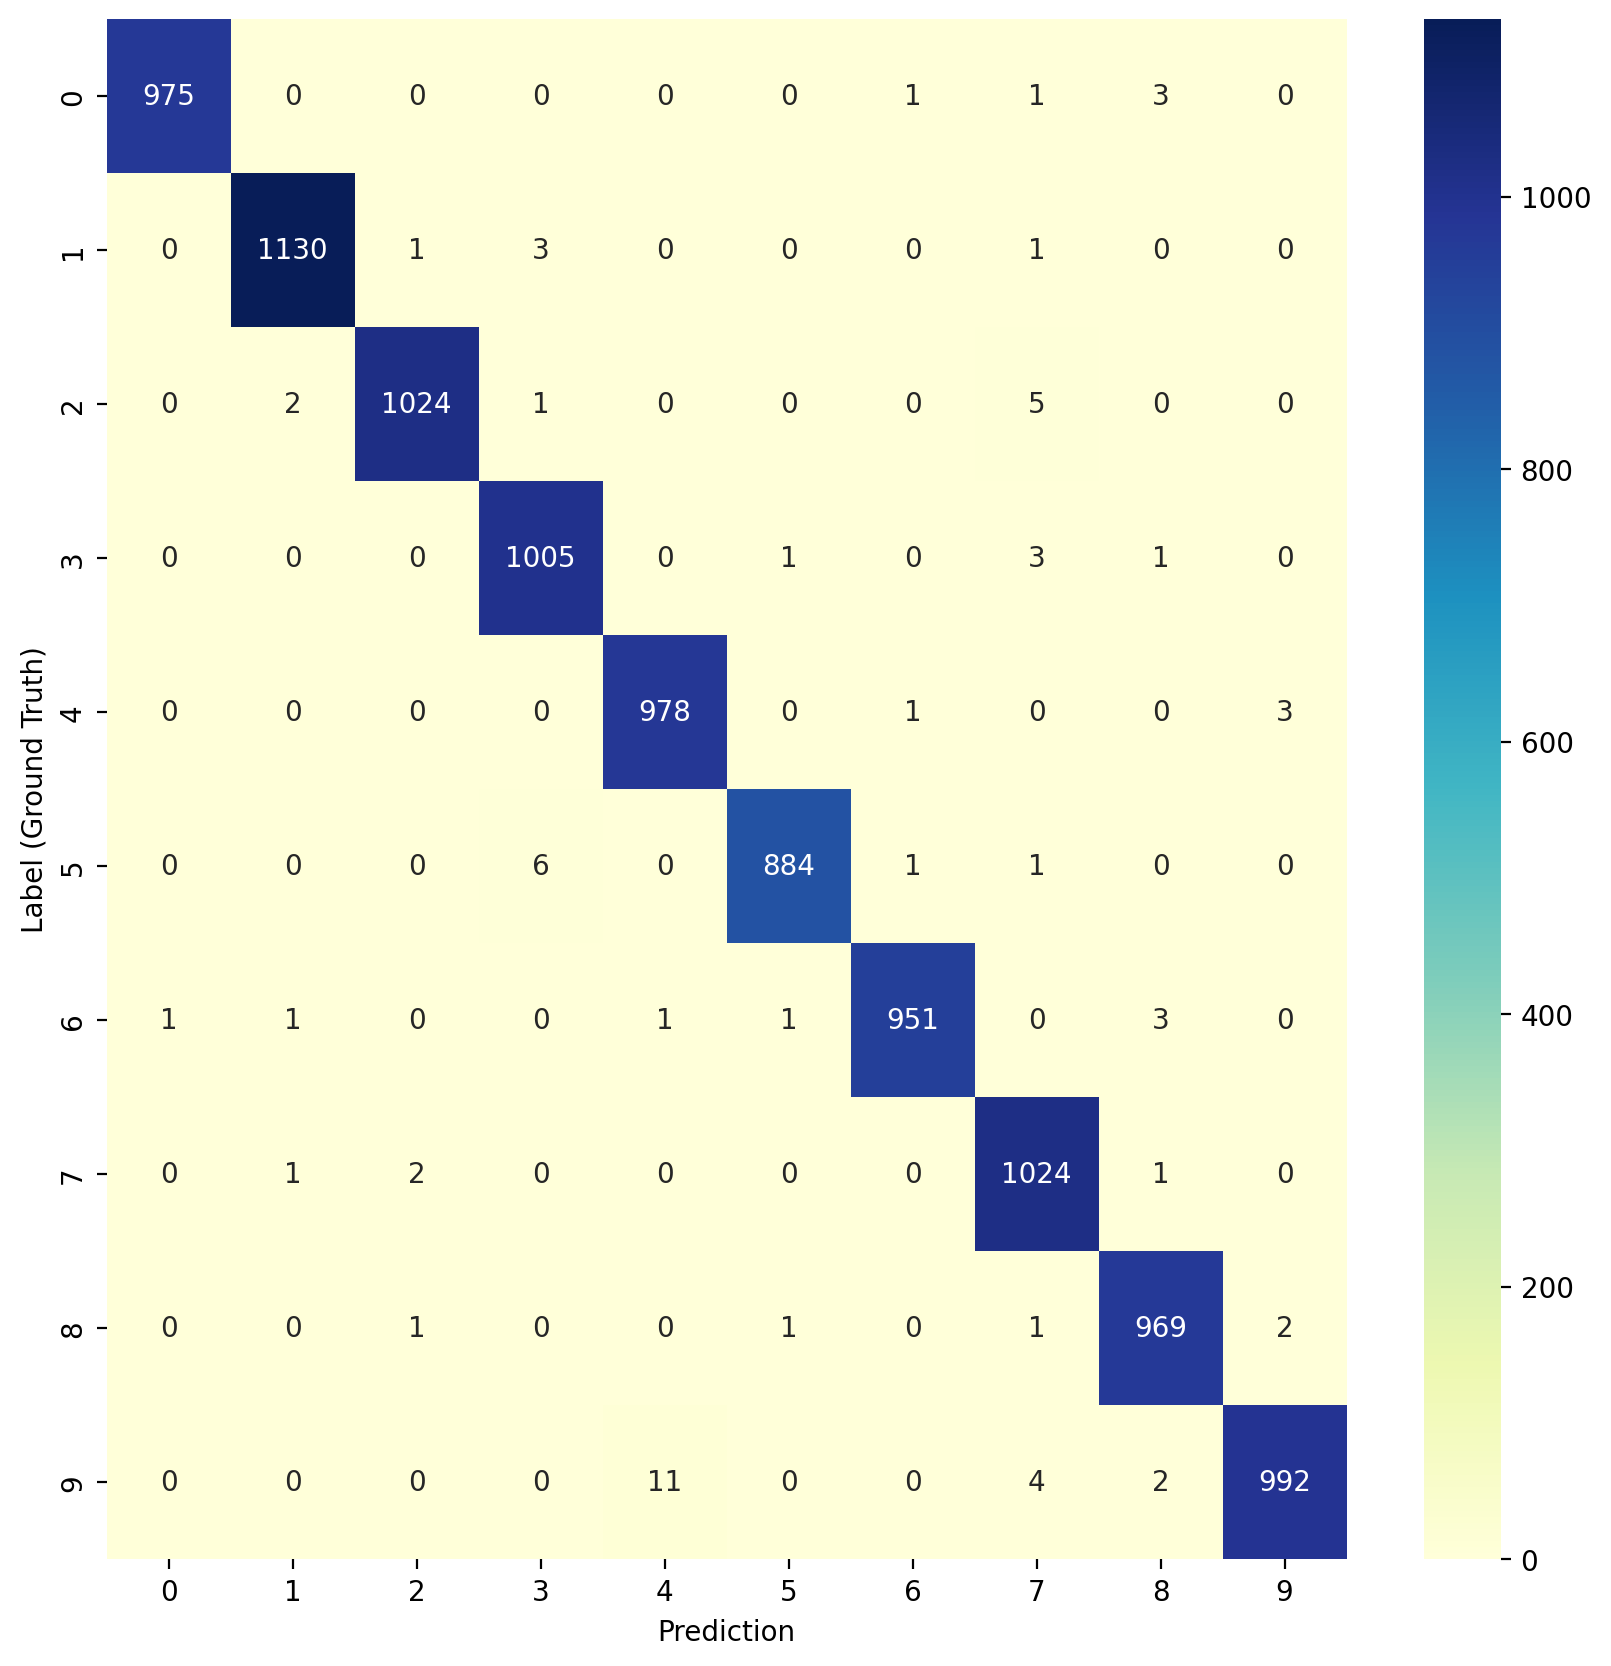

In [15]:
# confusion matrix 계산
model.eval()
with torch.no_grad():
    n_class = 10  # number of classes
    confusion_matrix = torch.zeros((n_class, n_class), dtype=torch.int64)
    for batch in test_iter:
        x, y = batch[0].to(device), batch[1].to(device)
        output = model(x)
        y_pred = output.argmax(dim=1)
        for i in range(len(y)):
            confusion_matrix[y[i], y_pred[i]] += 1
    
    # confusion matrix 출력 (pandas dataframe 사용, color map 사용)
    import pandas as pd
    import seaborn as sns
    plt.figure(figsize=(10,10))
    sns.heatmap(pd.DataFrame(confusion_matrix.numpy()),
                annot=True, fmt='d', cmap='YlGnBu')
    plt.xlabel('Prediction')
    plt.ylabel('Label (Ground Truth)')
    plt.show()
